# Appendix 1c. RMEstimator test with mock data - analysis

**Author: [Hannu Parviainen](mailto:hpparvi@gmail.com)** </br>
**Last edited: 19 September 2023**


In [446]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [447]:
import pandas as pd
import seaborn as sb

from warnings import catch_warnings, simplefilter
from pathlib import Path
from astropy.table import Table
from corner import corner
from arviz.stats import kde
from spright.rmrelation import RMRelation

AAOCW, AAPGW = 3.4645669, 7.0866142

In [448]:
files = {}
for f in  sorted(Path('.').glob('mock*.fits')):
    l = f.name.split('_')
    psize = int(l[1][2:])
    ws = int(l[2][3:])
    batch = int(l[3][1])
    files[psize, ws, batch] = f

In [449]:
rmrs = {(psize, ww, batch): RMRelation(f) for (psize, ww, batch),f in files.items()}

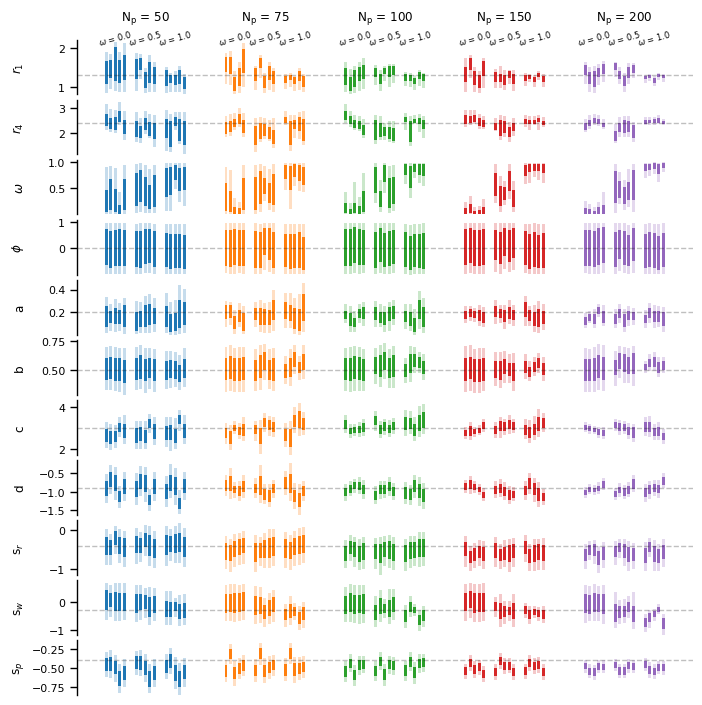

In [450]:
pnames = '$r_1$', '$r_4$', '$\omega$', '$\phi$', 'a', 'b', 'c', 'd', 's$_r$', 's$_w$', 's$_p$'
truths = 1.3, 2.4, 0.0, 0.0, 0.2, 0.5, 3.0, -0.9, -0.4, -0.3, -0.4

with sb.plotting_context('paper', font_scale=0.9):
    fig, axs = subplots(11, 1, figsize=(AAPGW, AAPGW), sharey='row')
    ixs = {50:0, 75:1, 100:2, 150:3, 200:4}
    iys = {0:0, 50:1, 100:2}
    with catch_warnings():
        simplefilter('ignore')
        for (psize, ww, batch), rmr in rmrs.items():
            for ip, p in enumerate(rmr.posterior_samples.columns):
                ax = axs[ip]
                pcs = percentile(rmr.posterior_samples[p], [50, 16, 84, 2.5, 97.5])
                xbatch = 0.15*batch - 0.5*4*0.15
                xww = iys[ww] - 1
                x = 4*ixs[psize] + xww + xbatch
                ax.bar(x, pcs[4]-pcs[3], bottom=pcs[3], width=0.1, fc=f'C{ixs[psize]}', alpha=0.25)
                ax.bar(x, pcs[2]-pcs[1], bottom=pcs[1], width=0.1, fc=f'C{ixs[psize]}')
    
    for ip, p in enumerate(rmr.posterior_samples.columns):
        setp(axs[ip], ylabel=pnames[ip])
        if ip != 2:
            axs[ip].axhline(truths[ip], c='k', ls='--', lw=1, alpha=0.25)
    
    ax = axs[0]
    yl = ax.get_ylim()
    yw = yl[1]-yl[0]
    for i, psize in enumerate((50, 75, 100, 150, 200)):
        ax.text(4*i, yl[1] + 0.25*yw, f"N$_\mathrm{{p}}$ = {psize}", va='bottom', ha='center')
        for j, ww in enumerate((0.0, 0.5, 1.0)):
            ax.text(4*i + j-1, yl[1] + 0.05*yw, f"$\omega$ = {ww}", va='center', ha='center', size=6, rotation=15)
    
    setp(axs, xticks=[])
    sb.despine(fig, bottom=True)
    fig.align_ylabels()
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.1)
    fig.savefig('A1_mock_posteriors.pdf')

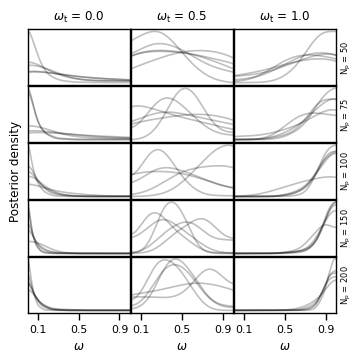

In [369]:
with sb.plotting_context('paper', font_scale=0.9):
    fig, axs = subplots(5, 3, figsize=(AAOCW, AAOCW), sharex='all')
    ixs = {50:0, 75:1, 100:2, 150:3, 200:4}
    iys = {0:0, 50:1, 100:2}
    with catch_warnings():
        simplefilter('ignore')
        for (psize, ww, batch),rmr in rmrs.items():
            x, y = kde(rmr.posterior_samples.ww.values, custom_lims=(0,1), bw_fct=3)
            ax = axs[ixs[psize], iys[ww]]
            ax.plot(x, y, 'k', alpha=0.25)
    setp(axs, yticks=[], xlim=(0,1))
    setp(axs[2,0], ylabel='Posterior density')
    setp(axs[-1], xlabel='$\omega$', xticks=[0.1, 0.5, 0.9])
    for i,ns in enumerate((50, 75, 100, 150, 200)):
        axs[i, -1].text(1.1, 0.5, f'N$_\mathrm{{p}}$ = {ns}', va='center', ha='center', transform=axs[i, -1].transAxes, size='x-small', rotation=90)
        #axs[i, -1].text(0.95, 0.9, f'N$_\mathrm{{s}}$ = {ns}', va='top', ha='right', transform=axs[i, 0].transAxes, size='x-small')
    for i,ww in enumerate((0.0, 0.5, 1.0)):
        axs[0,i].set_title(f'$\omega_\mathrm{{t}}$ = {ww}')
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.01, wspace=0.01, left=0.06, right=0.95, bottom=0.12, top=0.94)
    fig.savefig('pub_mock_ww_posteriors.pdf')

## Model selection tests

In [486]:
efiles = sorted(Path('.').glob('A1b_*np*_ws*.fits'))

In [487]:
dfs = []
for efile in efiles:
    df = Table.read(efile).to_pandas()
    df['hypothesis'] = df['hypothesis'].str.decode("utf-8")
    dfs.append(df)

In [488]:
dt = pd.concat(dfs).pivot(index=('psize', 'ws', 'ibatch'), columns='hypothesis')

In [489]:
db = pd.DataFrame([2 * (dt[('logz', 'H1')] - dt[('logz', 'H0')]),
                   2 * (dt[('logz', 'H2')] - dt[('logz', 'H0')]),
                   2 * (dt[('logz', 'H2')] - dt[('logz', 'H1')])]).T
db.columns = ['2B10', '2B20', '2B21']
db

B10        B20        B21
psize ws  ibatch                                 
50    0   0       -0.750579  -3.438960  -2.688381
          1       -1.243432  -4.367690  -3.124258
          2       -2.869154  -7.262303  -4.393150
          3       -2.238486  -6.369122  -4.130636
          4       -0.359298  -1.321070  -0.961772
...                     ...        ...        ...
200   100 15      45.997759  76.889889  30.892130
          16      35.906336  53.705940  17.799605
          17      50.448550  70.989345  20.540795
          18      38.527839  66.458934  27.931094
          19      58.121199  85.124666  27.003467

[280 rows x 3 columns]

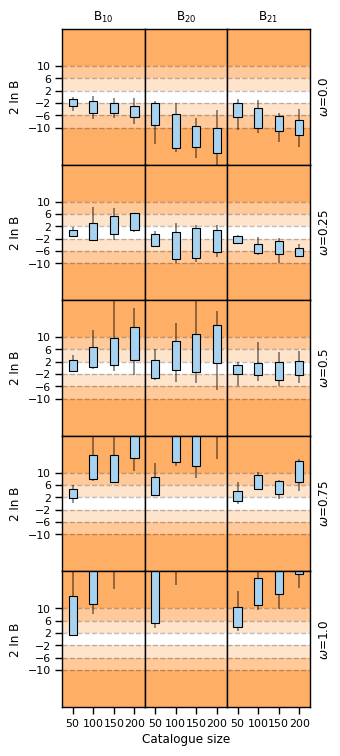

In [491]:
with sb.plotting_context('paper', font_scale=0.9):
    fig, axs = subplots(5, 3, figsize=(AAOCW, 2.2*AAOCW), sharey='row', sharex='all')
    for i,ws in enumerate((0,25,50,75,100)):
        t = db.xs(ws, level='ws').groupby('psize').quantile([0.5, 0.16, 0.84, 0.0, 1.0])
        for j,h in enumerate(('B10', 'B20', 'B21')):
            x = t[h].xs(0.16, level=1).index.values
            bottom = t[h].xs(0.16, level=1)
            height = (t[h].xs(0.84, level=1) - t[h].xs(0.16, level=1))
            axs[i,j].vlines(x, t[h].xs(0.0, level=1), t[h].xs(1.0, level=1), colors='k', zorder=0, alpha=0.5)
            axs[i,j].bar(x, height, bottom=bottom, width=20, ec='k', fc=sb.set_hls_values('C0', l=0.8))
        axs[i,2].text(1.1, 0.5, f'$\omega$={1e-2*ws}', va='center', rotation=90, transform=axs[i,2].transAxes)
    [[ax.axhline(v, c='k', ls='--', alpha=0.25, lw=1, zorder=0) for ax in axs.flat] for v in [-10, -6, -2, 2, 6, 10]]
    [[ax.axhspan(-v, v, fc=sb.set_hls_values('C1', l=0.7+0.1*ia), zorder=-10+ia) for ax in axs.flat]  for ia,v in enumerate([30, 10, 6, 2])]
    setp(axs[:,0], ylabel='2 ln B')
    setp(axs[-1], xticks=(50,100,150,200), xlim=(25,225))
    setp(axs[-1,1], xlabel='Catalogue size')

    axs[0,0].set_title('B$_{10}$')
    axs[0,1].set_title('B$_{20}$')
    axs[0,2].set_title('B$_{21}$')
    setp(axs, yticks=[-10, -6, -2, 2, 6, 10], ylim=(-22, 22))
    [setp(ax.get_yticklines(), visible=False) for ax in axs[:,1:].flat]
    fig.align_ylabels()
    fig.tight_layout()
    fig.subplots_adjust(wspace=0, hspace=0)
    fig.savefig('pub_mock_bf.pdf')

In [504]:
bmin = db.groupby(['psize','ws']).min()[['B10','B20']]
bmax = db.groupby(['psize','ws']).max()[['B10','B20']]

In [514]:
btb = pd.merge(bmin, bmax, left_index=True, right_index=True, suffixes=('_min', '_max')).iloc[:, [0,2,1,3]]
btb

B10_min    B10_max    B20_min     B20_max
psize ws                                              
50    0    -4.604947   0.047089 -15.267084   -1.272272
      25   -1.425189   1.633536  -4.546314    0.310462
      50   -1.272343   4.258980  -3.738217    6.120802
      75    0.223219   6.169169   2.630553   13.146573
      100   0.998691  25.275095   3.765539   39.007557
100   0    -7.079940   0.183923 -17.969054   -1.882255
      25   -2.541831   8.085944  -9.903981    2.951120
      50   -0.327947  12.191637  -4.466858   14.502681
      75    7.368515  22.843235  12.064235   33.239740
      100   8.191582  35.525152  17.608195   55.436431
150   0    -6.826034  -0.509347 -19.972930   -6.803114
      25   -2.537464   7.784103  -9.505856    2.300297
      50   -0.883064  22.183257  -4.775656   24.272690
      75    6.886752  22.094912   8.442853   28.253215
      100  16.347602  55.852591  30.950036   81.096300
200   0    -8.965023  -0.323168 -23.446882   -4.432141
      25    0.112440   6.436300  -7.913194    2.358357
      50   -2.227210  19.450878  -7.038285   18.426004
      75   10.464503  30.955205  14.544015   45.524017
      100  33.821674  71.393540  53.705940  118.027960

In [517]:
print(btb.round(1).to_latex(float_format="%.1f"))

\begin{tabular}{llrrrr}
\toprule
 &  & B10_min & B10_max & B20_min & B20_max \\
psize & ws &  &  &  &  \\
\midrule
\multirow[t]{5}{*}{50} & 0 & -4.6 & 0.0 & -15.3 & -1.3 \\
 & 25 & -1.4 & 1.6 & -4.5 & 0.3 \\
 & 50 & -1.3 & 4.3 & -3.7 & 6.1 \\
 & 75 & 0.2 & 6.2 & 2.6 & 13.1 \\
 & 100 & 1.0 & 25.3 & 3.8 & 39.0 \\
\cline{1-6}
\multirow[t]{5}{*}{100} & 0 & -7.1 & 0.2 & -18.0 & -1.9 \\
 & 25 & -2.5 & 8.1 & -9.9 & 3.0 \\
 & 50 & -0.3 & 12.2 & -4.5 & 14.5 \\
 & 75 & 7.4 & 22.8 & 12.1 & 33.2 \\
 & 100 & 8.2 & 35.5 & 17.6 & 55.4 \\
\cline{1-6}
\multirow[t]{5}{*}{150} & 0 & -6.8 & -0.5 & -20.0 & -6.8 \\
 & 25 & -2.5 & 7.8 & -9.5 & 2.3 \\
 & 50 & -0.9 & 22.2 & -4.8 & 24.3 \\
 & 75 & 6.9 & 22.1 & 8.4 & 28.3 \\
 & 100 & 16.3 & 55.9 & 31.0 & 81.1 \\
\cline{1-6}
\multirow[t]{5}{*}{200} & 0 & -9.0 & -0.3 & -23.4 & -4.4 \\
 & 25 & 0.1 & 6.4 & -7.9 & 2.4 \\
 & 50 & -2.2 & 19.5 & -7.0 & 18.4 \\
 & 75 & 10.5 & 31.0 & 14.5 & 45.5 \\
 & 100 & 33.8 & 71.4 & 53.7 & 118.0 \\
\cline{1-6}
\bottomrule
\end{tabula

---

<center>
©2023 Hannu Parviainen
</center>